# 偏西風の蛇行

2018年7月は西日本豪雨の後，梅雨明けとなり猛暑が続きました。

In [517]:
import numpy as np
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## 気候値

NCEP/NCAR再解析の月平均気候値と標準偏差を作成します。
提供されている気候値は1981年から2010年の平均ですが，ここでは月別データから1991年から2020年を平均して気候値を作成してみましょう。

対流圏上層の200 hPaとユーラシア大陸に着目して切り出します。
緯度が極から南向きであることに注意してください。

In [301]:
dods = "https://psl.noaa.gov/thredds/dodsC/Datasets"
lev = 200
t0, t1 = "1991-07", "2020-07"
lon0, lon1 = 0, 180
lat0, lat1 = 60, 0
vars = []
vars_stddev = []
for var in ["hgt", "uwnd", "vwnd"]:
    ds = xr.open_dataset(f"{dods}/ncep.reanalysis.derived/pressure/{var}.mon.mean.nc")
    x = ds[var].loc[t0:t1:12, lev, lat0:lat1, lon0:lon1]
    vars.append(x.mean(axis=0))
    vars_stddev.append(x.std(axis=0))
ds_clim = xr.merge(vars)
ds_stddev = xr.merge(vars_stddev)

気候値では，ユーラシア大陸上にチベット高気圧があります。
北半球夏季モンスーンの影響でベンガル湾で対流が活発となり，対流圏下層の低気圧に対応してチベット高気圧ができます。
地球の回転の効果により，ベンガル湾のある東経90度よりも中心がやや西にずれるのが特徴です。
チベット高気圧の目安はジオポテンシャル高度12500 mです。
チベット高気圧の北側北緯40度付近にはアジアジェットが形成されます。

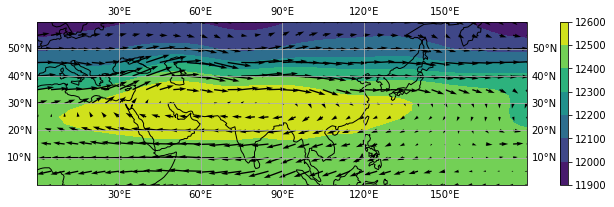

In [518]:
fig = plt.figure(figsize=[12, 3])
ax = fig.add_subplot(projection=ccrs.PlateCarree())

p = ax.contourf(ds_clim.lon, ds_clim.lat, ds_clim.hgt,
          transform=ccrs.PlateCarree())
ax.quiver(ds_clim.lon[::2], ds_clim.lat[::2], ds_clim.uwnd[::2,::2], ds_clim.vwnd[::2,::2],
          transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.colorbar(p)
plt.show()

## 2018年7月

次に2018年7月のデータを取得して気候値と比較してみましょう。

In [520]:
vars = []
for var in ["hgt", "uwnd", "vwnd"]:
    ds = xr.open_dataset(f"{dods}/ncep.reanalysis.derived/pressure/{var}.mon.mean.nc")
    vars.append(ds[var].loc["2018-07", lev, lat0:lat1, lon0:lon1][0])
ds = xr.merge(vars)

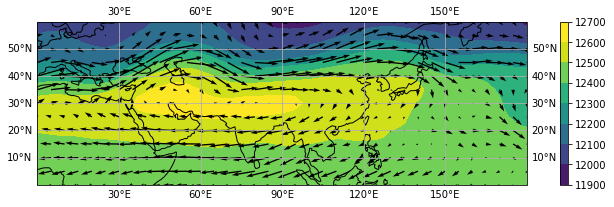

In [521]:
fig = plt.figure(figsize=[12, 3])
ax = fig.add_subplot(projection=ccrs.PlateCarree())

p = ax.contourf(ds.lon, ds.lat, ds.hgt,
                vmin=11900, vmax=12600,
          transform=ccrs.PlateCarree())
ax.quiver(ds.lon[::2], ds.lat[::2], ds.uwnd[::2,::2], ds.vwnd[::2,::2],
          transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.colorbar(p)
plt.show()

12500 mの等値線は東西に伸びていて，12600 mの等値線もあり，チベット高気圧が平年よりも強いことが分かります。

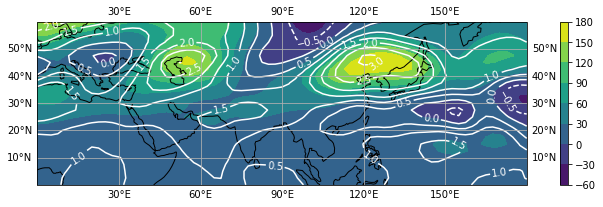

In [524]:
hgt_anom = (ds.hgt - ds_clim.hgt)
hgt_anom_norm = hgt_anom / ds_stddev.hgt

fig = plt.figure(figsize=[12, 3])
ax = fig.add_subplot(projection=ccrs.PlateCarree())

p = ax.contourf(ds.lon, ds.lat, hgt_anom,
          transform=ccrs.PlateCarree())
c = ax.contour(ds.lon, ds.lat, hgt_anom_norm, colors=["white"])
ax.clabel(c)
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.colorbar(p)
plt.show()

差を取るとカスピ海付近と中国東北部で北に張り出しているという特徴が明瞭です。
特に中国東北部の偏差は標準偏差の3倍（3$\sigma$）に達しています。
高度偏差は偏西風に沿って，低気圧，高気圧，低気圧，高気圧と並んでいるように見えます。

## ロスビー波束の伝播

大規模な偏西風の蛇行は，地球の回転を復元力とする波動，ロスビー波によるものです。
ロスビー波の位相は西進する性質がありますが，西風と釣り合うことで位相が止まって見えます。
これを定常ロスビー波といいます。
興味深いことに，定常ロスビー波の群速度（エネルギーの伝播速度）は東向きで，
速さは理論的には東西風速の最大2倍です。
日々対流圏上層で偏西風の蛇行が見られるときは，位相つまり凹凸の経度方向の位置はそのままで，振幅だけが東に移動していきます。
まさに蛇が進む様子に似ています。

日別データを用いて偏西風の蛇行の様子を確認します。
ジオポテンシャル高度の東西平均からのずれを時系列で見てます。
偏西風の蛇行，つまり偏西風に沿った波の伝播が見られる北緯35度から北緯50度までを平均します。
結果として，経度と時間の座標が残ります。
東西時間断面図をホフメラー図{cite}`Hovmoller:1949`と呼びます。


In [304]:
yyyy = 2018
d0, d1 = f"{yyyy}-07-01", f"{yyyy}-07-31"
lat0, lat1 = 60, 0
lev = 200
ds_daily = xr.open_dataset(f"{dods}/ncep.reanalysis.dailyavgs/pressure/hgt.{yyyy}.nc")
hgt = ds_daily.hgt.loc[d0:d1, lev, lat0:lat1, :]
hgt_hov = hgt.loc[:, 50:35, :].mean(axis=1)

Hovmöllerは時刻を上から下に取りましたので，これに倣って`ax.invert_yaxis()`によりy軸を反転させます。
y軸の範囲を`ax.set_ylim([time[-1], time[0]])`のように逆にすることでも反転できます。
`.roll()`メソッドで経度を60度東にずらしています。
座標を単調増加にするためにずらした座標から360を引いています。

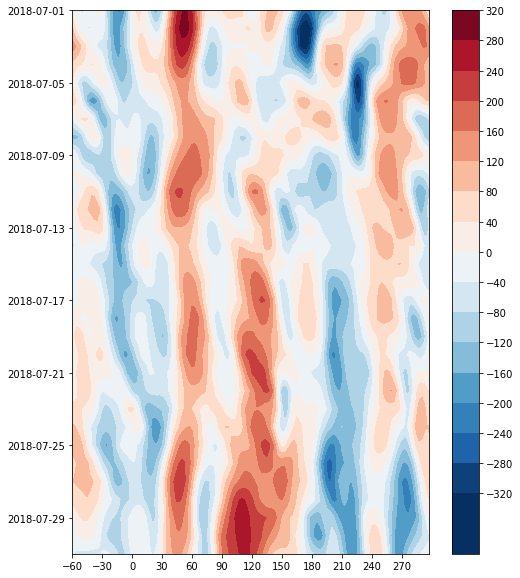

In [305]:
from matplotlib.dates import date2num, num2date

fig, ax = plt.subplots(figsize=[8, 10])
hgt_anomaly = hgt_hov - hgt_hov.mean(axis=1)
time = num2date(date2num(hgt_anomaly.time))
i_roll = int(60 / 2.5)
hgt_anomaly_roll = hgt_anomaly.roll(lon=i_roll, roll_coords=True)
lon = hgt_anomaly_roll.lon.data
lon[:i_roll] -= 360
vmin, vmax = -320, 320
nlevs = 17
p = ax.contourf(lon, time, hgt_anomaly_roll, cmap="RdBu_r",
               levels=nlevs, vmin=vmin, vmax=vmax)
ax.set_xticks(lon[::i_roll//2])
ax.invert_yaxis()
fig.colorbar(p, ticks=np.linspace(vmin, vmax, nlevs))
plt.show()

7月中旬から日本の西方東経120度付近の高気圧が波束の到達と共に発達していく様子が明瞭に現れています。
東経45度付近の気圧の峰は月を通じて強かったようです。

### 波の活動度フラックス

波束の伝播をより定量的に捉えるために，波の活動度フラックス{cite}`Takaya-Nakamura:2001`を計算して描画します。
日本付近の高気圧が強化された7月下旬に着目します。

In [527]:
yyyy = 2018
mmdd0, mmdd1 = "07-16", "07-31"
d0, d1 = f"{yyyy}-{mmdd0}", f"{yyyy}-{mmdd1}"
z = hgt.loc[d0:d1, :, lon0:lon1].mean(axis=0)

日別気候値から作成した半月の平均を基本場と見なすことにします。
何を基本場とみなすかには任意性があります。
時間移動平均や高波数を落として空間的に滑らかにした場を用いることもあります。

In [528]:
vars = []
yyyy = "0001"
d0, d1 = f"{yyyy}-{mmdd0}", f"{yyyy}-{mmdd1}"
for var in ["hgt", "uwnd", "vwnd"]:
    ds = xr.open_dataset(f"{dods}/ncep.reanalysis.derived/pressure/{var}.day.ltm.nc")
    x = ds[var].loc[d0:d1, lev, lat0:lat1, lon0:lon1]
    vars.append(x.mean(axis=0))
z0, u0, v0 = vars[0], vars[1], vars[2]

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, 

MetPyにはこれを計算する関数は用意されていませんが，勾配を計算する`metpy.calc.gradient()`を用います。
勾配を計算する際，引数が持つ座標を利用して，地球の形状や半径は考慮されます。
返り値が配列の添え字の順序通りなので，緯度，経度方向の勾配であることに注意しましょう。

In [529]:
from metpy.constants import earth_avg_radius, earth_gravity, earth_avg_angular_vel

def wave_activity_flux(u0, v0, zp, lat):
    f = 2 * np.pi * earth_avg_angular_vel * np.sin(np.deg2rad(lat))
    psip = earth_gravity * zp / f
    py, px = mpcalc.gradient(psip)
    pxy, pxx = mpcalc.gradient(px)
    pyy, pyx = mpcalc.gradient(py)
    w_x = u0*(px**2 - psip*pxx) + v0 * (px*py - psip*pxy)
    w_y = u0*(px*py - psip*pxy) + v0 * (py**2 - psip*pyy)
    dw = mpcalc.divergence(w_x, w_y)
    return w_x, w_y, dw

In [530]:
wx, wy, dw = wave_activity_flux(u0, v0, z-z0, 40*units.degree)

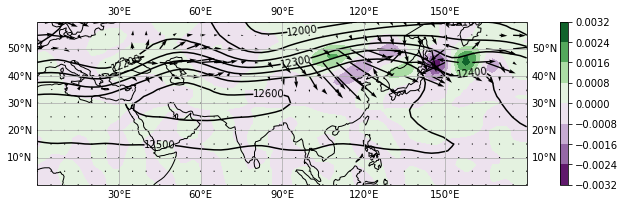

In [531]:
fig = plt.figure(figsize=[12, 3])
ax = fig.add_subplot(projection=ccrs.PlateCarree())

p = ax.contourf(z.lon, z.lat, dw, transform=ccrs.PlateCarree(), cmap="PRGn")
c = ax.contour(z.lon, z.lat, z, transform=ccrs.PlateCarree(), colors=["black"])
ax.quiver(z.lon[::2], z.lat[::2], wx[::2,::2], wy[::2,::2],
          transform=ccrs.PlateCarree(), scale=10000)
ax.coastlines()
ax.clabel(c)
ax.gridlines(draw_labels=True)
fig.colorbar(p)
plt.show()

波束が偏西風帯を伝播し，日本付近で収束することにより高気圧偏差が形成・維持されたことを示唆する結果が得られました。